# 
<h1 style="color: teal;">2D Deconvolution Benchmark: Julia</h1>

---
## Setup

In [2]:
using DeconvOptim, TestImages, Colors, ImageIO, Noise, ImageShow, Images, Plots, BenchmarkTools, FFTW

---
## Test Image

Una vez importados los paquetes lo que hemos hecho ha sido coger una imagen de prueba, añadirla borrosidad y ruido y hacer la deconvolución en 2D sin regularizar.
Usaremos la misma PSF para el código en python y el mismo número de iteraciones.


In [9]:
# Cargar la imagen de prueba
img = load("ImagenPrueba.jpg")
img = Float32.(img)

# Generar la PSF (Point Spread Function)
psf = Float32.(generate_psf(size(img), 30))

# Crear una versión borrosa y ruidosa de la imagen
img_b = conv(img, psf)  # Imagen borrosa
img_n = poisson(img_b, 300)  # Imagen borrosa y ruidosa
;
# Guardar la imagen borrosa y ruidosa
# save("blurrednoisy_img.jpg", img_b)


In [10]:
img = load("ImagenesEmpleadas2D/ImagenPrueba.jpg")
img = Float32.(img)

psf = load("ImagenesEmpleadas2D/psf.jpg")
psf = Float32.(psf);
# Deconvolución 2D sin regularizador
res_no_reg, o = deconvolution(img_n, ifftshift(psf), regularizer=nothing, iterations=30)

# Medir el tiempo de ejecución de la deconvolución

b = @benchmark  deconvolution(img_n, ifftshift(psf), regularizer=nothing, iterations=30) samples=15 evals=1

BenchmarkTools.Trial: 15 samples with 1 evaluation.
 Range (min … max):  227.643 ms … 356.589 ms  ┊ GC (min … max):  0.00% … 36.28%
 Time  (median):     237.820 ms               ┊ GC (median):     5.44%
 Time  (mean ± σ):   280.151 ms ±  56.289 ms  ┊ GC (mean ± σ):  19.03% ± 16.29%

  █  █▃                                                 ▃        
  █▁▁██▁▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇█▇▇▁▁▁▇ ▁
  228 ms           Histogram: frequency by time          357 ms <

 Memory estimate: 173.58 MiB, allocs estimate: 5829.

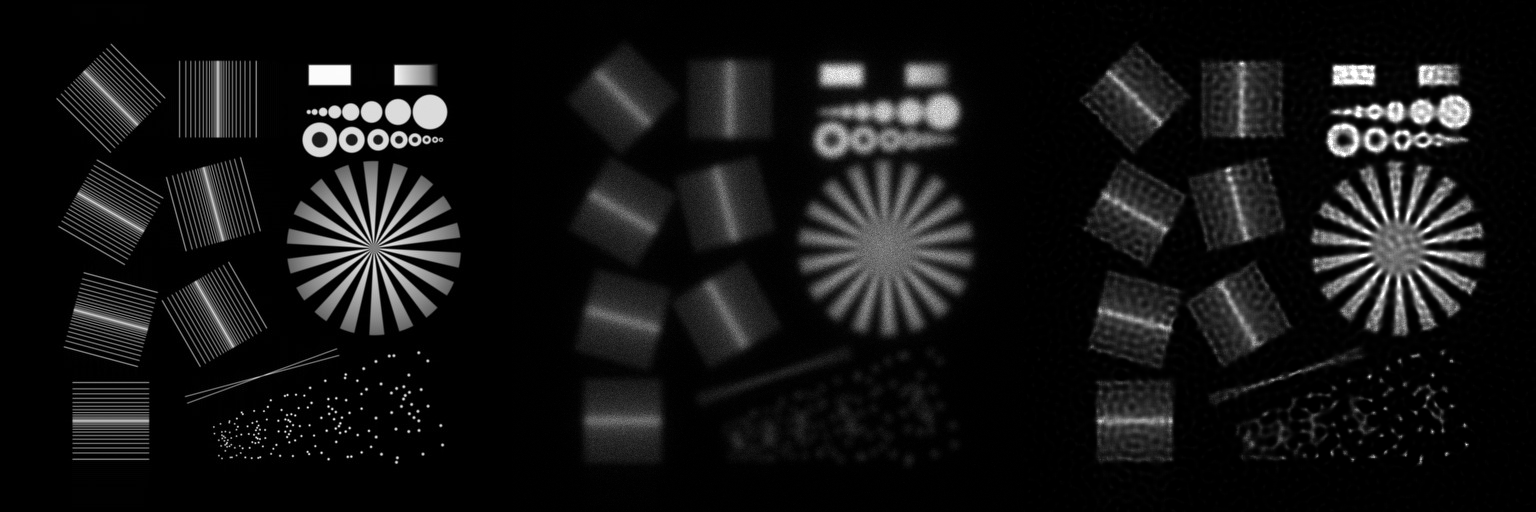

In [11]:
# Mostrar los resultados finales junto a la versión original y la versión borrosa
Gray.([img img_n res_no_reg])

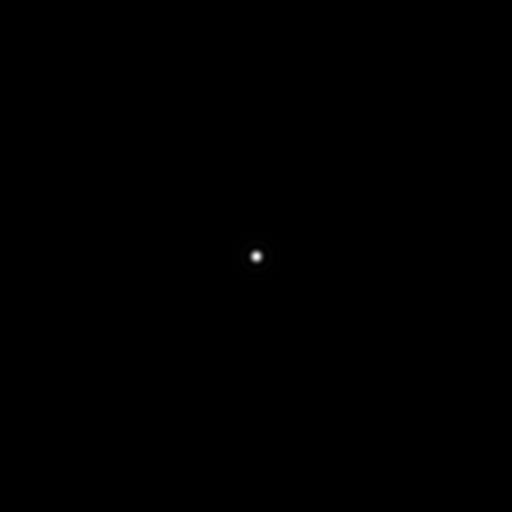

In [7]:
# Suponemos que psf ya está definida
# Normaliza los valores de la PSF al rango [0, 1]
psf_min = minimum(psf)
psf_max = maximum(psf)
psf_normalized = (psf .- psf_min) ./ (psf_max - psf_min)
psf_gray = Gray.(psf_normalized)  # Convertir a escala de grises

# Centrar la PSF utilizando ifftshift
centered_psf = ifftshift(psf_normalized)
centered_psf_gray = Gray.(centered_psf)  # Convertir a escala de grises

# Guardar la PSF normalizada como una imagen JPEG
# save("psf.jpg", centered_psf_gray)

# Mostrar la PSF centrada
display(centered_psf_gray)


Ahora vamos a usar la función richardson_lucy_iterative del módulo deconvoptim.jl sin regularización.

In [8]:
# Deconvolución iterativa de Richardson-Lucy sin regularizador
restored_img = richardson_lucy_iterative(img_n, psf; regularizer=nothing, iterations=30);

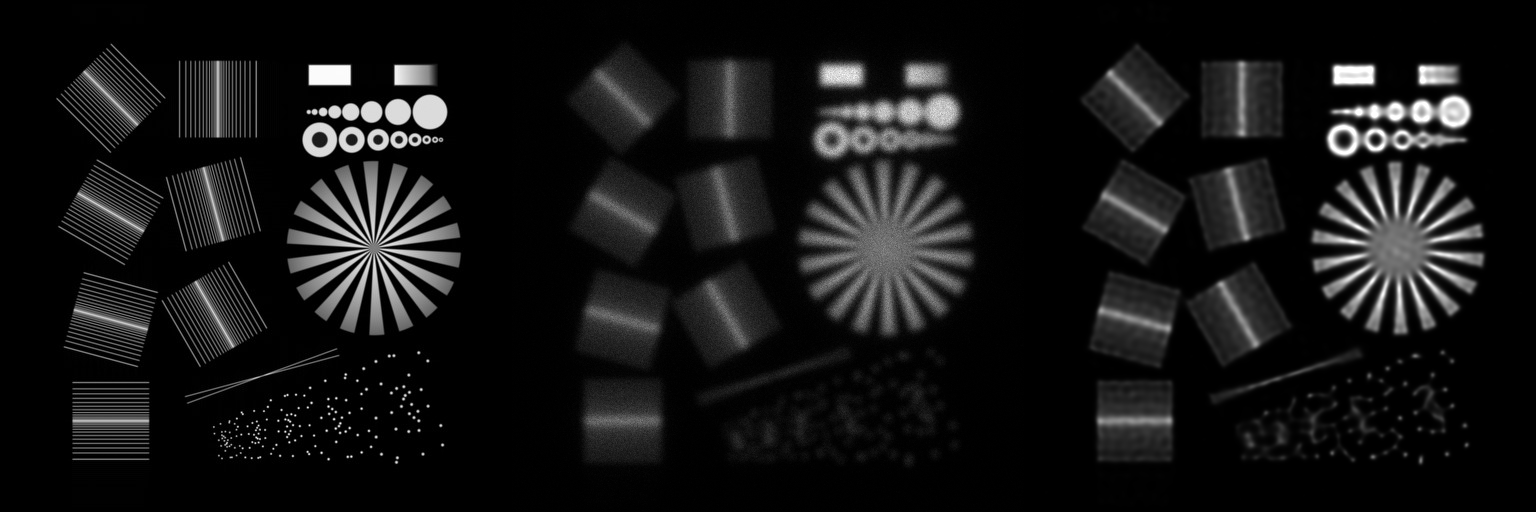

In [9]:
Gray.([img img_n restored_img])

In [10]:
c = @benchmark richardson_lucy_iterative(img_n, psf; regularizer=nothing, iterations=30) samples=100 evals=1 seconds=60

BenchmarkTools.Trial: 100 samples with 1 evaluation.
 Range (min … max):  58.066 ms … 80.142 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     58.702 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   59.194 ms ±  2.410 ms  ┊ GC (mean ± σ):  0.48% ± 1.70%

    ▂█▇                                                        
  ▂▃███▃▁▁▁▃▁▂▁▁▃▁▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂ ▂
  58.1 ms         Histogram: frequency by time        67.8 ms <

 Memory estimate: 7.01 MiB, allocs estimate: 33.

Veremos ahora ejemplos con TV regularization en Julia

In [11]:
# Deconvolución iterativa de Richardson-Lucy con regularizador
optim_res = richardson_lucy_iterative(img_n, psf, λ=0.05, regularizer=TV(), iterations=30)
d1 = @benchmark richardson_lucy_iterative(img_n, psf, λ=0.05, regularizer=TV(), iterations=30) samples=100 evals=1 seconds=60

BenchmarkTools.Trial: 100 samples with 1 evaluation.
 Range (min … max):  286.179 ms … 321.503 ms  ┊ GC (min … max): 1.71% … 5.14%
 Time  (median):     292.838 ms               ┊ GC (median):    2.34%
 Time  (mean ± σ):   293.642 ms ±   4.692 ms  ┊ GC (mean ± σ):  2.49% ± 0.76%

           ▄ ▄▁▃▃█▄█    ▄   ▃                                    
  ▆▄▄▁▁▆▄▇▆█▇███████▇▆▄▇█▆▄▆█▆▁▄▁▄▄▆▁▄▁▁▄▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄ ▄
  286 ms           Histogram: frequency by time          311 ms <

 Memory estimate: 76.59 MiB, allocs estimate: 633614.

In [12]:
# Deconvolución iterativa de Richardson-Lucy con regularizador (optimizada)
tv = TV()

#887 (generic function with 1 method)

In [13]:
d2 = @benchmark richardson_lucy_iterative(img_n, psf, λ=0.05, regularizer=tv, iterations=30) samples=100 evals=1 seconds=60

BenchmarkTools.Trial: 100 samples with 1 evaluation.
 Range (min … max):  77.191 ms … 99.970 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     79.233 ms              ┊ GC (median):    1.77%
 Time  (mean ± σ):   79.391 ms ±  2.474 ms  ┊ GC (mean ± σ):  1.55% ± 1.48%

      ▂      ▃ ▂ █▂                                            
  ▇█▇▅█▆▅▇▃▆▇█▆████▇▆▆▃▃▁▆▃▃▅▁▅▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃ ▃
  77.2 ms         Histogram: frequency by time        86.3 ms <

 Memory estimate: 38.04 MiB, allocs estimate: 1057.

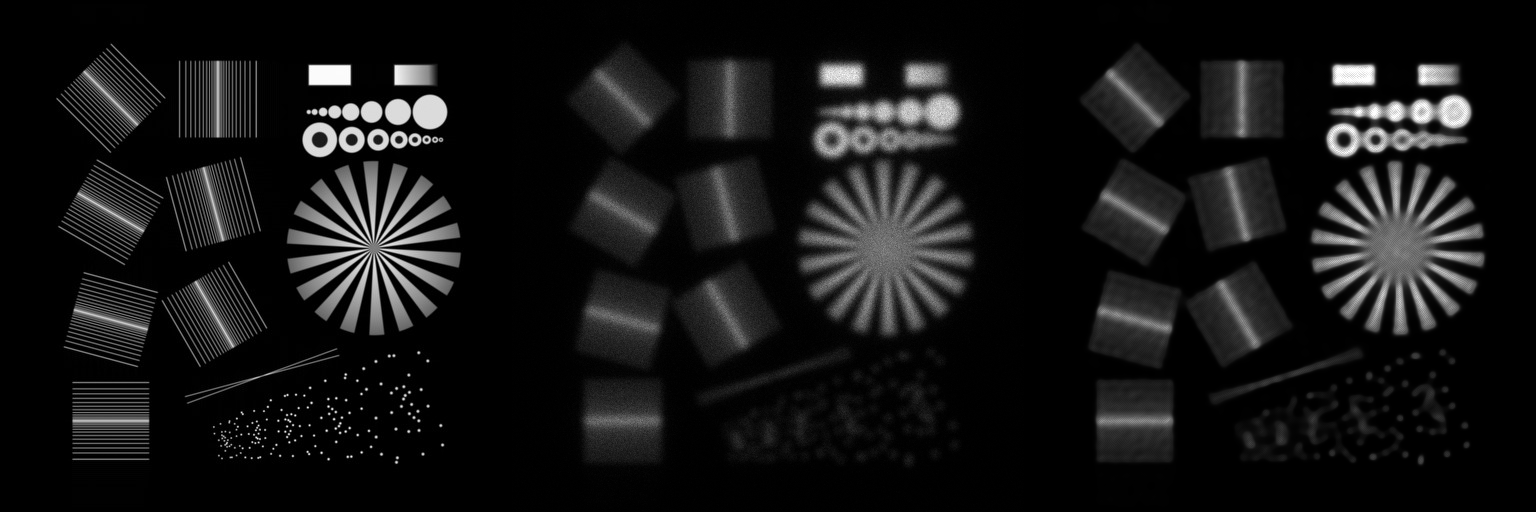

In [14]:
Gray.([img img_n optim_res])

---
## Cell
Test usando solo el plano central del `cells3D` dataset

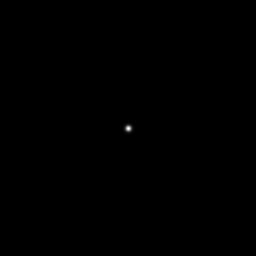

In [15]:
img = load("cells3d_convolved.tif")
img = Float32.(img)

psf = load("cells3d_psf.tif")
psf = Float32.(psf);

Gray.(psf/maximum(psf))

In [16]:
ipsf = ifftshift(psf);

In [17]:
deconvolved = richardson_lucy_iterative(img, ipsf; regularizer=nothing, iterations=30);

In [18]:
 c = @benchmark richardson_lucy_iterative(img, ipsf; regularizer=nothing, iterations=30) samples=100 evals=1 seconds=60

BenchmarkTools.Trial: 100 samples with 1 evaluation.
 Range (min … max):  15.124 ms … 35.395 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     15.391 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   15.716 ms ±  2.203 ms  ┊ GC (mean ± σ):  0.47% ± 3.18%

  ▄██                                                          
  ████▅▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅ ▅
  15.1 ms      Histogram: log(frequency) by time      23.3 ms <

 Memory estimate: 1.76 MiB, allocs estimate: 33.

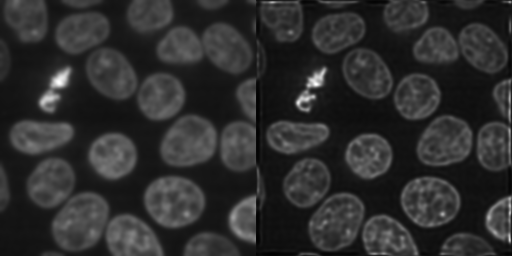

In [19]:
Gray.([img/maximum(img) deconvolved/maximum(deconvolved)])